In [ ]:
!pip install numpy==1.23.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request

!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

import librosa
import librosa.display
from IPython.display import Audio

In [ ]:
txt_data = pd.read_csv("/content/drive/MyDrive/BOAZ_MiniProject1/data/df_calculation.csv", encoding= 'utf-8')
# txt_data = pd.read_csv("/content/df_calculation.csv", encoding= 'utf-8')
print(f"txt_data 길이: {len(txt_data)}")
print(f"txt_data shape: {txt_data.shape}")

txt_data 길이: 15463
txt_data shape: (15463, 6)


In [ ]:
txt_data.head()

,Unnamed: 0,wav_id,text,situation,emotion,label
0,0,5f4141e29dd513131eacee2f,헐! 나 이벤트에 당첨 됐어.,happiness,happiness,1
1,1,5f4141f59dd513131eacee30,내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.,happiness,happiness,1
2,2,5f4142119dd513131eacee31,"한 명 뽑는 거였는데, 그게 바로 내가 된 거야.",happiness,happiness,1
3,3,5f4142279dd513131eacee32,"당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. ...",happiness,happiness,1
4,4,5f3c9ed98a3c1005aa97c4bd,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,neutral,happiness,1


In [ ]:
txt_data.rename(columns={'emo_num':'label'}, inplace=True)
new_txt_data = txt_data[['wav_id', 'text', 'label']]
new_txt_data.head()

,wav_id,text,label
0,5f4141e29dd513131eacee2f,헐! 나 이벤트에 당첨 됐어.,1
1,5f4141f59dd513131eacee30,내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.,1
2,5f4142119dd513131eacee31,"한 명 뽑는 거였는데, 그게 바로 내가 된 거야.",1
3,5f4142279dd513131eacee32,"당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. ...",1
4,5f3c9ed98a3c1005aa97c4bd,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,1


#### 음성 데이터 로드

In [ ]:
# # 데이터 15,000 기준 압축 해제 15분 소요
# %cd '/content/drive/MyDrive/BOAZ_MiniProject1'
# !zip -FFv '5차년도_2차.zip' --out 'audio_data/5차년도_2차_fixed.zip'
# !unzip -qq 'audio_data/5차년도_2차_fixed.zip' -d 'audio_data/'

In [ ]:
audio_path = '/content/drive/MyDrive/BOAZ_MiniProject1/audio_data'
wav_list = txt_data['wav_id']+'.wav'
wav_list_tmp = txt_data['wav_id']+'.wav'

wav_list_tmp_id = txt_data['wav_id']

wav_list_tmp_label, wav_list_tmp_sentence = [], []
for x in wav_list_tmp_id:
    # Check if wav_id exists in the DataFrame before accessing the label
    if x in new_txt_data['wav_id'].values:
        wav_list_tmp_label.append(new_txt_data[new_txt_data['wav_id'] == x]['label'].values[0])
        wav_list_tmp_sentence.append(new_txt_data[new_txt_data['wav_id'] == x]['text'].values[0])
    else:
        print(f"Warning: wav_id '{x}' not found in new_txt_data")
        # Handle missing data, e.g., append empty strings or NaN to all lists
        wav_list_tmp_id.remove(x) # Remove the id from the list as well
        wav_list_tmp_label.append(None)  # Or any placeholder
        wav_list_tmp_sentence.append(None)

wav_df = pd.DataFrame(
    {'wav_id': wav_list_tmp_id,
     'final_label': wav_list_tmp_label,
     'sentence': wav_list_tmp_sentence
    })

<ipython-input-11-61d308f4f34f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = wav_df['final_label'], palette = "husl",  ax = ax)


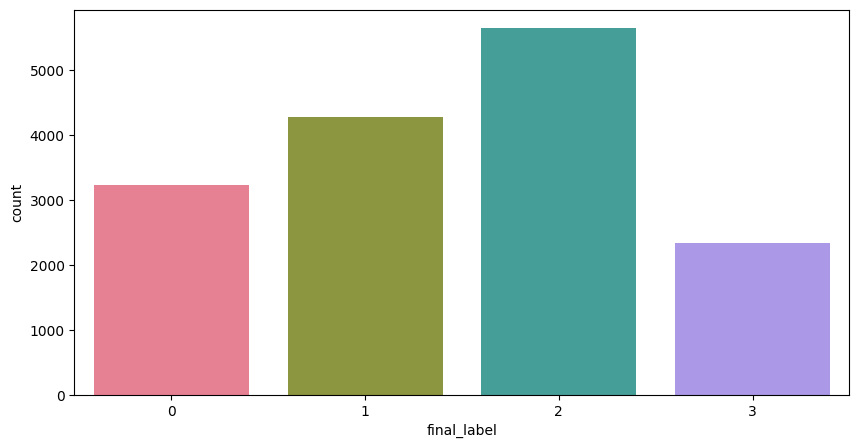

In [ ]:
# 라벨 분포 확인
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x = wav_df['final_label'], palette = "husl",  ax = ax)
plt.show()

#### (2) 음성 데이터 feature vector 추출

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [ ]:
import numpy as np
import pandas as pd
import librosa

def noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

def extract_features(data, sample_rate):
    # Using Mel spectrogram instead of MFCC
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=13)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    mel_mean = mel_spectrogram_db.mean(axis=1)
    return mel_mean

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.0)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.concatenate((result, res2), axis=0)

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.concatenate((result, res3), axis=0)

    return result

X_audio, Y = [], []
for path, label in zip(wav_df['wav_id'], wav_df['final_label']):
    audio_features = get_features(audio_path+'/'+path+'.wav')
    X_audio.append(audio_features)
    Y.append(label)

audio_features_df = pd.DataFrame(X_audio)
final_df = pd.concat([audio_features_df, wav_df[['wav_id', 'final_label', 'sentence']]], axis=1)
final_df.head(3)


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,wav_id,final_label,sentence
0,-29.468798,-31.240356,-38.848953,-40.914436,-44.581768,-44.417805,-47.801220,-54.250778,-57.902264,-62.485432,...,-45.022797,-51.482948,-55.834831,-59.878666,-68.687149,-70.414734,-65.861801,5f4141e29dd513131eacee2f,1,헐! 나 이벤트에 당첨 됐어.
1,-30.099411,-31.936836,-41.053654,-47.526344,-50.544041,-52.571609,-54.472904,-56.056156,-55.974014,-59.748173,...,-54.129951,-55.734428,-56.106380,-59.102871,-65.948387,-69.371544,-64.576561,5f4141f59dd513131eacee30,1,내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.
2,-36.655167,-38.963005,-49.742268,-52.676640,-53.806244,-54.051060,-57.111019,-59.885712,-60.253399,-66.104111,...,-55.871662,-59.654465,-59.753307,-64.566338,-69.171631,-69.056831,-67.324554,5f4142119dd513131eacee31,1,"한 명 뽑는 거였는데, 그게 바로 내가 된 거야."


In [ ]:
final_df = pd.read_csv("/content/drive/MyDrive/BOAZ_MiniProject1/data/audio_features.csv", encoding= 'utf-8')

#### 텍스트 embedding vector 추출

In [ ]:
import numpy as np
import pandas as pd
import librosa

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# Instead of importing np_utils, just use to_categorical directly
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
class text_embedding():
  def __init__(self, model_name):
    self.model_name = model_name

  def fit(self, X, y=None):
        return self

  def transform(self, X):
        embedding_model = SentenceTransformer(self.model_name, device=device) # Use the device variable here
        embedding_vec = embedding_model.encode(X['sentence'])
        X_val = np.concatenate((X.drop(['final_label', 'wav_id', 'sentence'], axis = 1), embedding_vec), axis = 1)
        return X_val

In [ ]:
from transformers import AutoTokenizer

# KoBERT 전용 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1")

def text_embedding(model_name):
    if model_name == 'skt/kobert-base-v1':
        # KoBERT 모델용 임베딩 함수 구현
        def transform(dataframe):
            # 텍스트 데이터를 KoBERT 전용 토크나이저로 변환
            tokenized_data = dataframe['sentence'].apply(lambda x: tokenizer(x, return_tensors="pt", padding=True, truncation=True, max_length=128))
            return tokenized_data
        return transform
    else:
        # 다른 모델용 임베딩 함수 (기존 코드)
        return SomeOtherEmbeddingFunction(model_name)

#### 모델링

In [ ]:
def custom_model(x_train):
  model=Sequential()
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Flatten())
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(0.3))

  # Change the number of units in the final Dense layer to match the number of classes
  model.add(Dense(units=4, activation='softmax'))  # 4 classes instead of 6
  model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

  #model.summary()
  return model

# Define rlrp outside the function so it's accessible in the global scope
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=3, min_lr=1e-6) #learning rate 조절

scaler = StandardScaler()
encoder = OneHotEncoder()

In [ ]:
!pip install onnxruntime==1.12.0
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-v_5z5_wy/kobert-tokenizer_f72eeb9f3ecd498f895d547c9a1dab16
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-v_5z5_wy/kobert-tokenizer_f72eeb9f3ecd498f895d547c9a1dab16
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=5c97cf807124483d72ca28b7c1def434901e2544f6b646b6366275eac11597b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_tquutka/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenize

In [ ]:
!pip install transformers
!pip install sentence_transformers

In [ ]:
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
import numpy as np

class text_embedding:
  def __init__(self, model_name):
    self.model_name = model_name

  def transform(self, X):
    if self.model_name == 'skt/kobert-base-v1':
        # Use KoBERTTokenizer for skt/kobert-base-v1
        tokenizer = BertTokenizer.from_pretrained('skt/kobert-base-v1')
        model = BertModel.from_pretrained('skt/kobert-base-v1')
        # Tokenize the sentences
        inputs = tokenizer(X['sentence'].tolist(), return_tensors='pt', padding=True, truncation=True)
        # Get the embeddings
        outputs = model(**inputs)
        embedding_vec = outputs.last_hidden_state[:, 0, :].detach().numpy()
        X_val = np.concatenate((X.drop(['final_label', 'wav_id', 'sentence'], axis=1), embedding_vec), axis=1)
    else:
        # For other models, use SentenceTransformer
        embedding_model = SentenceTransformer(self.model_name)
        embedding_vec = embedding_model.encode(X['sentence'])
        X_val = np.concatenate((X.drop(['final_label', 'wav_id', 'sentence'], axis=1), embedding_vec), axis=1)
    return X_val

In [ ]:
import os
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 필수 패키지 설치
!pip install scikit-learn

# 전처리 및 모델 학습 코드
pre_trained_models = [
    'klue/roberta-base',
    'monologg/koelectra-base-discriminator'
]

Y = final_df['final_label'].values
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

# 결과 저장 디렉토리 설정
save_dir = '/content/drive/MyDrive/BOAZ_MiniProject1/model_results'
os.makedirs(save_dir, exist_ok=True)

def sanitize_filename(filename):
    return filename.replace('/', '_').replace(':', '_')

for model_name in pre_trained_models:
    # 텍스트 임베딩 변환
    txt_embed = text_embedding(model_name=model_name)
    X = txt_embed.transform(final_df)

    # 데이터 분할
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 차원 확장
    x_train = np.expand_dims(x_train, axis=2)
    x_test = np.expand_dims(x_test, axis=2)

    # 모델 생성 및 학습
    model = custom_model(x_train)
    history = model.fit(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_test, y_test), callbacks=[rlrp])

    # 모델 평가
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print("Pre-trained Model: ", model_name)
    print("Test Accuracy: ", test_acc)

    # 예측 및 평가
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    # 결과 출력
    print("Pre-trained Model: ", model_name)
    print("Test Accuracy: ", test_acc)
    print("F1 Score: ", f1)

    # 파일 이름 sanitize
    sanitized_model_name = sanitize_filename(model_name)

    # 파일 저장
    np.save(os.path.join(save_dir, f'{sanitized_model_name}_predictions.npy'), y_pred_classes)
    np.save(os.path.join(save_dir, f'{sanitized_model_name}_true_labels.npy'), y_test_classes)
    np.save(os.path.join(save_dir, f'{sanitized_model_name}_probabilities.npy'), y_pred)

    print(f"Saved prediction results for {model_name}")
    print("-----------------------------")


Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 428s 550ms/step - accuracy: 0.3519 - loss: 1.3578 - val_accuracy: 0.4504 - val_loss: 1.2420 - learning_rate: 0.0010
Epoch 2/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 385s 497ms/step - accuracy: 0.4460 - loss: 1.2342 - val_accuracy: 0.5011 - val_loss: 1.1436 - learning_rate: 0.0010
Epoch 3/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 381s 492ms/step - accuracy: 0.5000 - loss: 1.1267 - val_accuracy: 0.5639 - val_loss: 1.0422 - learning_rate: 0.0010
Epoch 4/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 386s 499ms/step - accuracy: 0.5256 - loss: 1.0921 - val_accuracy: 0.5671 - val_loss: 1.0265 - learning_rate: 0.0010
Epoch 5/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 440s 496ms/step - accuracy: 0.5403 - loss: 1.0618 - val_accuracy: 0.5917 - val_loss: 0.9937 - learning_rate: 0.0010
Epoch 6/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 382s 494ms/step - accuracy: 0.5415 - loss: 1.0453 - val_accuracy: 0.5988 - val_loss: 0.9716 - learning_rate: 0.0010
Epoch 7/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 440s 492ms/step - accura

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/279k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 394s 507ms/step - accuracy: 0.3631 - loss: 1.3568 - val_accuracy: 0.3679 - val_loss: 1.3424 - learning_rate: 0.0010
Epoch 2/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 440s 505ms/step - accuracy: 0.3670 - loss: 1.3397 - val_accuracy: 0.3679 - val_loss: 1.3337 - learning_rate: 0.0010
Epoch 3/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 456s 523ms/step - accuracy: 0.3635 - loss: 1.3356 - val_accuracy: 0.3679 - val_loss: 1.3332 - learning_rate: 0.0010
Epoch 4/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 425s 502ms/step - accuracy: 0.3609 - loss: 1.3391 - val_accuracy: 0.3679 - val_loss: 1.3331 - learning_rate: 0.0010
Epoch 5/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 443s 504ms/step - accuracy: 0.3600 - loss: 1.3393 - val_accuracy: 0.3679 - val_loss: 1.3333 - learning_rate: 0.0010
Epoch 6/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 460s 527ms/step - accuracy: 0.3594 - loss: 1.3383 - val_accuracy: 0.3679 - val_loss: 1.3332 - learning_rate: 0.0010
Epoch 7/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 389s 503ms/step - accura